In [1]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from scipy import stats
from functions import *
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [3]:
Food = pd.read_csv('Food_pour_analyse.csv', low_memory=False)

In [4]:
Food.head(5)

,code,url,product_name,brands,countries_fr,ingredients_text,additives_n,additives,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,40608754,http://world-fr.openfoodfacts.org/produit/0000...,"Pepsi, Nouveau goût !",Pepsi,France,"Eau gazéifiée, sucre, colorant caramel E150d, ...",2.0,[ eau-gazeifiee -> fr:eau-gazeifiee ] [ eau...,e,177.0,0.0,0.0,10.4,10.4,0.0,0.0,0.0254,0.010000,13.0
1,10,http://world-fr.openfoodfacts.org/produit/0000...,Madeleines nature,Bijou,France,"Farine de _blé_, huile de colza, sucre, _oeufs...",5.0,[ farine-de-ble -> fr:farine-de-ble ] [ far...,d,1900.0,23.0,2.5,55.0,26.0,1.5,6.0,0.6600,0.259843,12.0
2,30,http://world-fr.openfoodfacts.org/produit/0000...,Cakes Raisins,Bijou,France,"Farine de _blé_, _œufs_ frais, huile de colza,...",5.0,[ farine-de-ble -> fr:farine-de-ble ] [ far...,d,1768.0,19.0,2.5,56.0,28.0,1.8,5.8,0.6500,0.255906,13.0
3,31,http://world-fr.openfoodfacts.org/produit/0000...,Cakes aux Fruits,Bijou,France,"Fruits 37.4% [fruits confits 21,5% [fruits (pa...",11.0,[ fruits-37-4 -> fr:fruits-37-4 ] [ fruits-...,d,1670.0,15.0,2.0,60.0,34.0,1.5,4.9,0.6000,0.236220,12.0
4,50,http://world-fr.openfoodfacts.org/produit/0000...,Financiers aux Amandes,Bijou,France,"Sucre, blanc d’_œufs_ frais, poudre d’_amande_...",3.0,[ sucre -> fr:sucre ] [ blanc-d-oeufs-frais...,e,1868.0,23.0,10.0,51.0,39.0,1.7,8.0,0.5500,0.216535,22.0


In [5]:
Food.describe()

,code,additives_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,2.398200e+04,23982.000000,23982.000000,23982.000000,23982.000000,23982.000000,23982.000000,23982.000000,23982.000000,23982.000000,23982.000000,23982.000000
mean,3.905535e+12,1.944083,1067.860423,11.324897,4.389345,30.282703,12.672159,2.705090,7.161811,0.918023,0.361429,6.526603
std,7.076769e+12,2.522556,743.013209,14.125250,7.092909,26.970801,17.704681,3.873309,6.806557,3.274882,1.289369,8.968316
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,3.245414e+12,0.000000,385.000000,1.200000,0.200000,6.400000,1.300000,0.500000,2.000000,0.064008,0.025200,-1.000000
50%,3.288133e+12,1.000000,981.000000,5.500000,1.400000,19.000000,4.100000,1.800000,5.900000,0.530000,0.208661,5.000000
75%,3.585510e+12,3.000000,1632.000000,17.600000,5.500000,56.000000,16.975000,3.500000,9.800000,1.100000,0.433071,14.000000
max,3.564707e+14,21.000000,3464.000000,100.000000,87.000000,100.000000,100.000000,100.000000,86.000000,100.000000,39.370079,35.000000


In [6]:
Food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23982 entries, 0 to 23981
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   code                     23982 non-null  int64  
 1   url                      23982 non-null  object 
 2   product_name             23982 non-null  object 
 3   brands                   23982 non-null  object 
 4   countries_fr             23982 non-null  object 
 5   ingredients_text         23982 non-null  object 
 6   additives_n              23982 non-null  float64
 7   additives                23982 non-null  object 
 8   nutrition_grade_fr       23982 non-null  object 
 9   energy_100g              23982 non-null  float64
 10  fat_100g                 23982 non-null  float64
 11  saturated-fat_100g       23982 non-null  float64
 12  carbohydrates_100g       23982 non-null  float64
 13  sugars_100g              23982 non-null  float64
 14  fiber_100g            

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


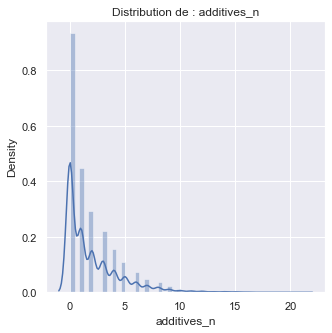

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


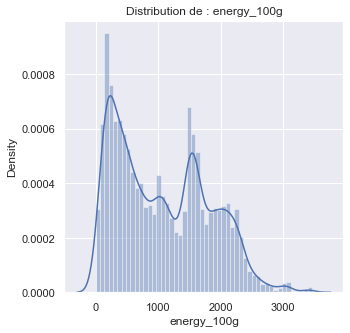

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


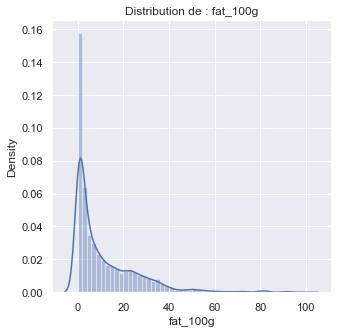

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


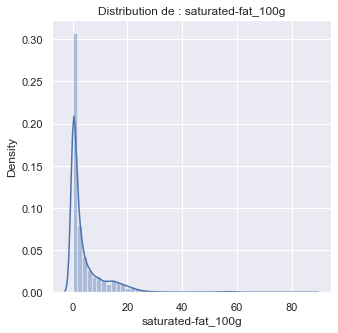

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


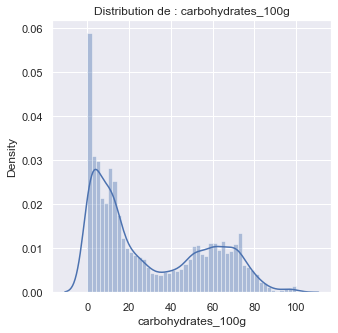

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


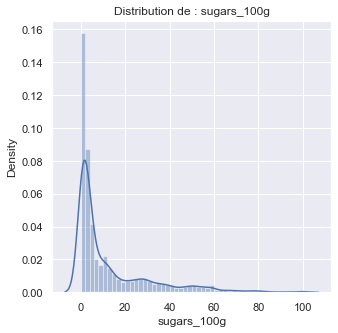

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


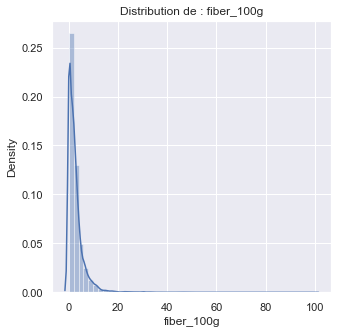

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


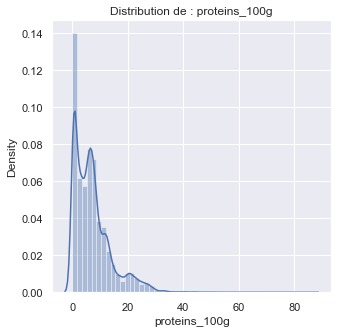

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


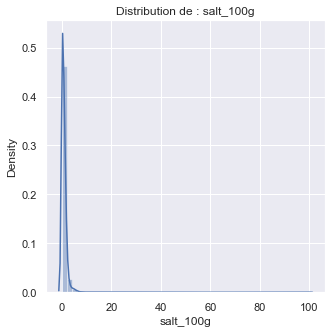

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


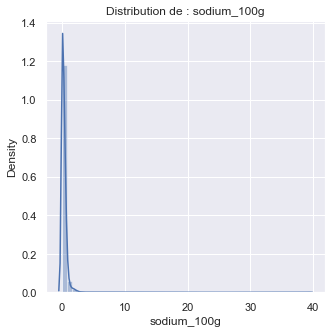

/Users/gauthierrault/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


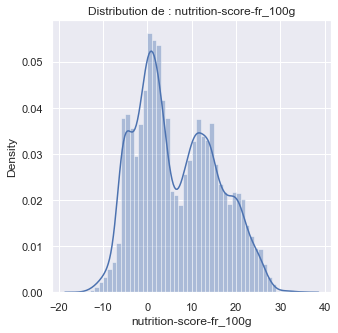

In [7]:
numeric_columns = Food.select_dtypes(include = ['float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (5,5))
    sns.set(font_scale=1)
    sns.distplot(Food[column], bins=50)
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

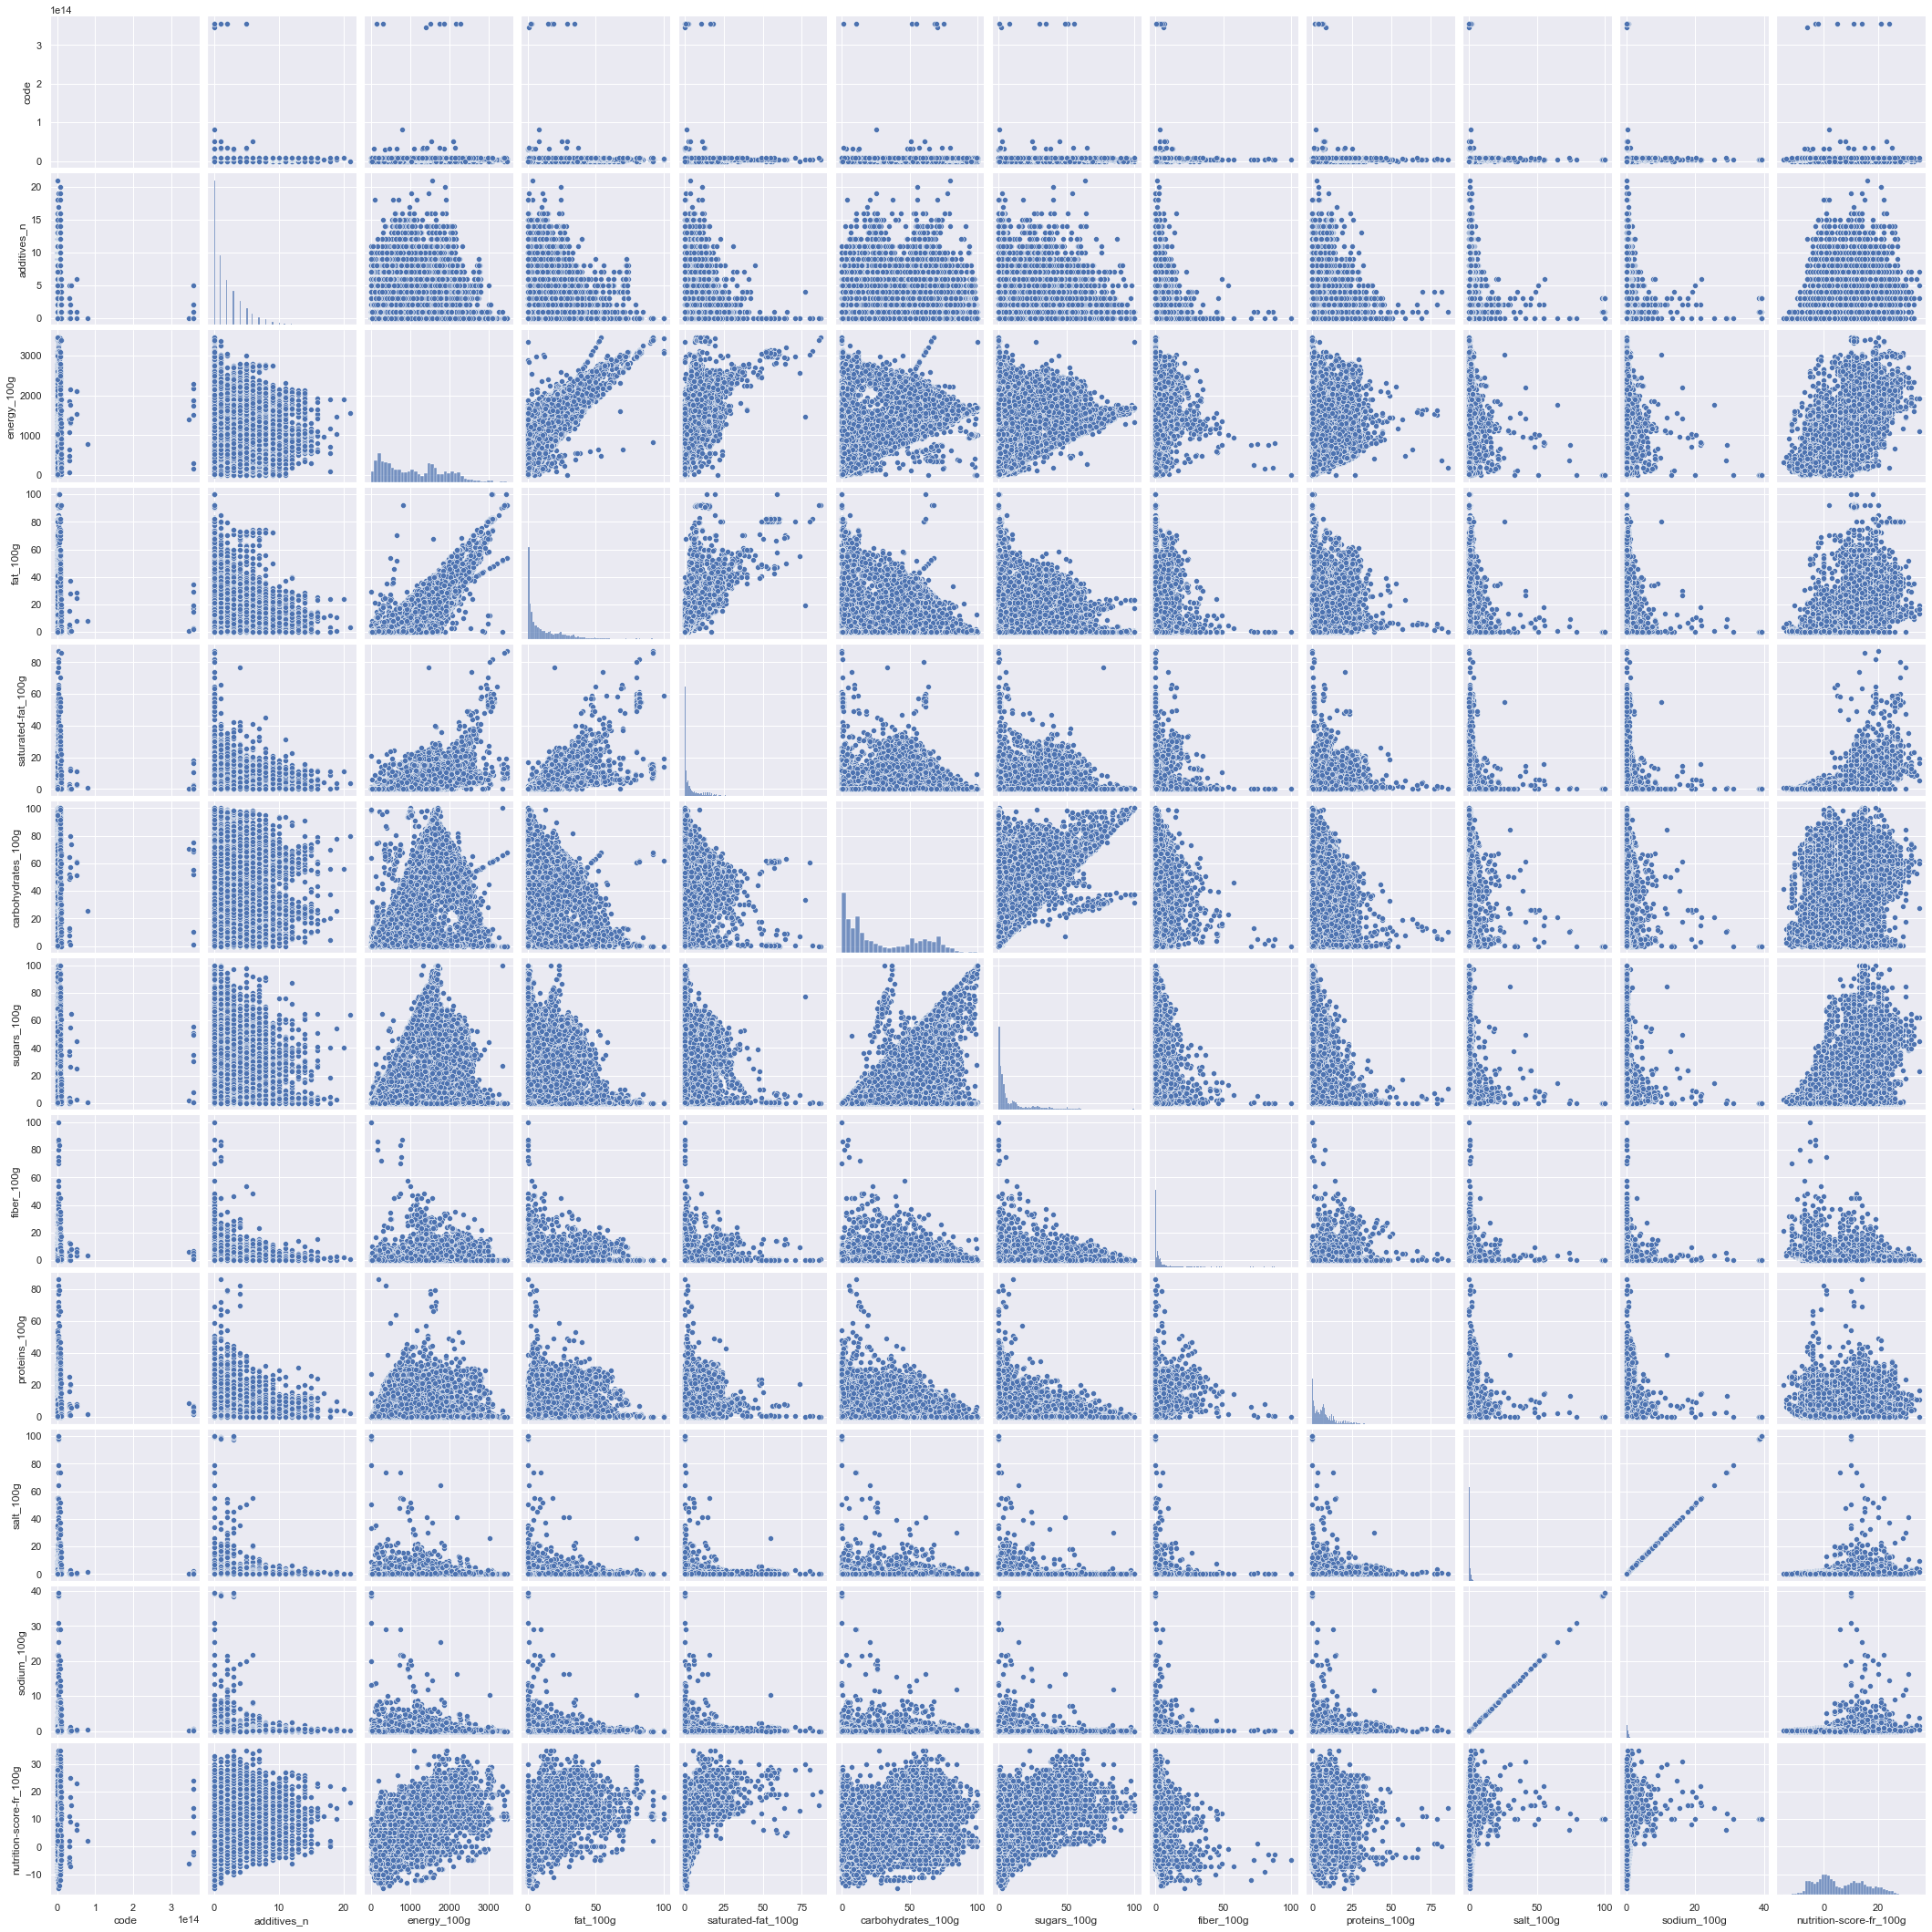

In [8]:
sns.pairplot(Food.iloc[:,0:19])

Si γ1=0 alors la distribution est symétrique.

Si γ1>0 alors la distribution est étalée à droite.

Si γ1<0 alors la distribution est étalée à gauche.

In [9]:
Food['additives_n'].skew()

1.9204369532951946

In [10]:
Food['fat_100g'].skew()

2.024272423708855

In [11]:
Food['saturated-fat_100g'].skew()

3.381277900082121

In [12]:
Food['carbohydrates_100g'].skew()

0.5498243555498299

In [13]:
Food['sugars_100g'].skew()

1.9629982488295041

In [14]:
Food['fiber_100g'].skew()

6.356907170952115

In [15]:
Food['proteins_100g'].skew()

1.8737928027002484

In [16]:
Food['salt_100g'].skew()

22.334092628276732

In [17]:
Food['sodium_100g'].skew()

22.33344559549542

In [18]:
Food['nutrition-score-fr_100g'].skew()

0.327753896535887

Si γ2=0 , alors la distribution a le même aplatissement que la distribution normale.

Si γ2>0 , alors elle est moins aplatie que la distribution normale : les observations sont plus concentrées.

Si γ2<0 , alors les observations sont moins concentrées : la distribution est plus aplatie.

In [19]:
Food['additives_n'].kurtosis()

4.74797200659016

In [20]:
Food['fat_100g'].kurtosis()

5.497363447488971

In [21]:
Food['saturated-fat_100g'].kurtosis()

18.38485227405255

In [22]:
Food['carbohydrates_100g'].kurtosis()

-1.1387798007860332

In [23]:
Food['sugars_100g'].kurtosis()

3.734241490752111

In [24]:
Food['fiber_100g'].kurtosis()

85.98453702883465

In [25]:
Food['proteins_100g'].kurtosis()

7.079739280807682

In [26]:
Food['salt_100g'].kurtosis()

609.3430590400072

In [27]:
Food['sodium_100g'].kurtosis()

609.2981130491614

In [28]:
Food['nutrition-score-fr_100g'].kurtosis()

-0.8504278982936908

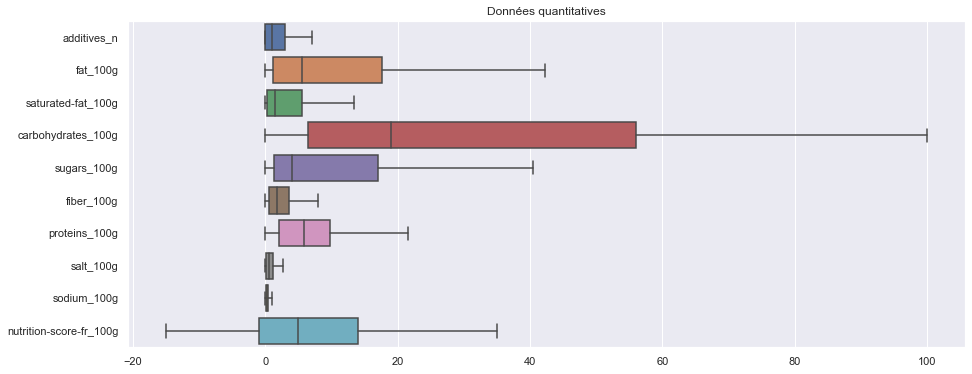

In [29]:
quant_variables = ['additives_n','fat_100g',
                   'saturated-fat_100g',
         'carbohydrates_100g','sugars_100g', 'fiber_100g', 'proteins_100g',
         'salt_100g','sodium_100g',  'nutrition-score-fr_100g']

fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
sns.boxplot(data=Food[quant_variables], orient='h', showfliers=False).set_title('Données quantitatives');

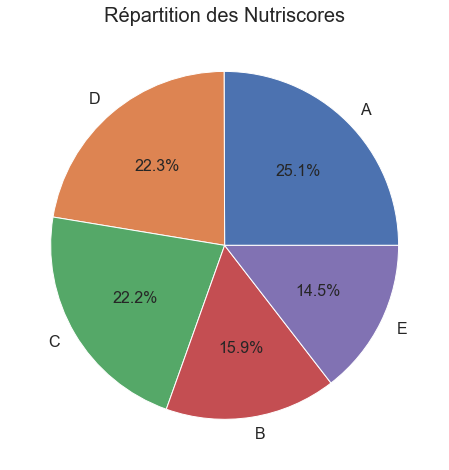

In [33]:
plt.figure(figsize=(8,8))

plt.title('Répartition des Nutriscores', size=20)
wedges, texts, autotexts = plt.pie(Food.nutrition_grade_fr.value_counts().values, 
        labels = Food.nutrition_grade_fr.value_counts().index.str.upper(),
       autopct='%1.1f%%', textprops={'fontsize': 16}
       )


<AxesSubplot:title={'center':'Nutriscore pour fat'}, xlabel='fat_100g', ylabel='nutrition_grade_fr'>

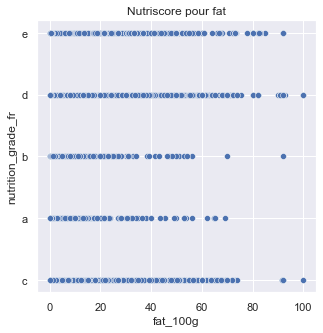

In [30]:
plt.figure(figsize=(5,5))
plt.title('Nutriscore pour fat')
sns.scatterplot( x = Food['fat_100g'], y = Food['nutrition_grade_fr'])

<AxesSubplot:title={'center':'Nutriscore pour sugars'}, xlabel='sugars_100g', ylabel='nutrition_grade_fr'>

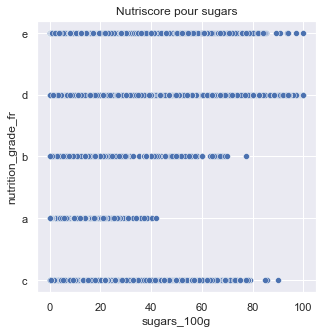

In [31]:
plt.figure(figsize=(5,5))
plt.title('Nutriscore pour sugars')
sns.scatterplot( x = Food['sugars_100g'], y = Food['nutrition_grade_fr'])

<AxesSubplot:title={'center':'Nutriscore pour fiber'}, xlabel='fiber_100g', ylabel='nutrition_grade_fr'>

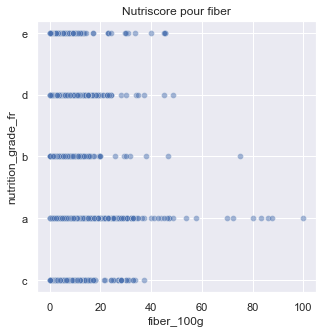

In [32]:
plt.figure(figsize=(5,5))
plt.title('Nutriscore pour fiber')
sns.scatterplot( x = Food['fiber_100g'], y = Food['nutrition_grade_fr'], alpha=0.5)

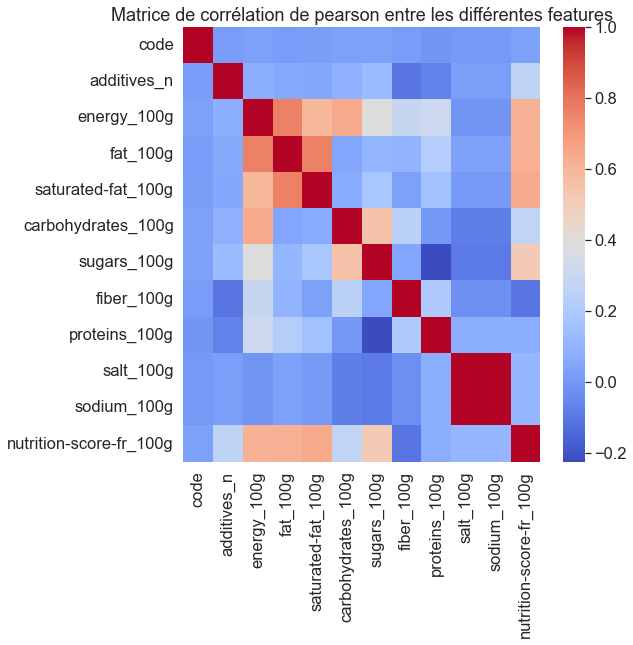

In [34]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
plt.title('Matrice de corrélation de pearson entre les différentes features')

sns.heatmap(Food.corr(), cmap='coolwarm')
plt.show()

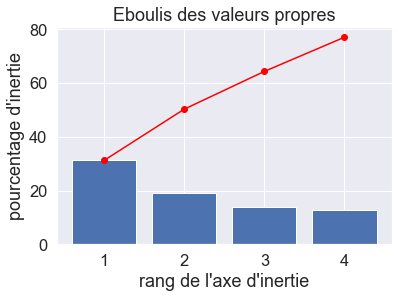

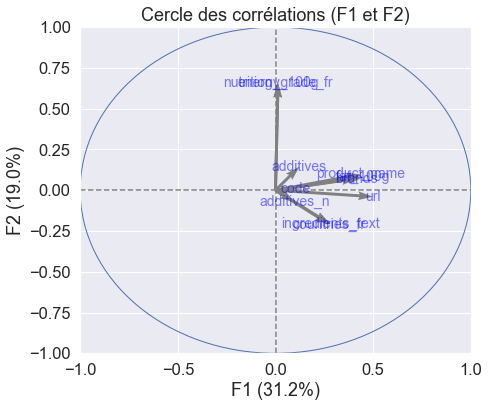

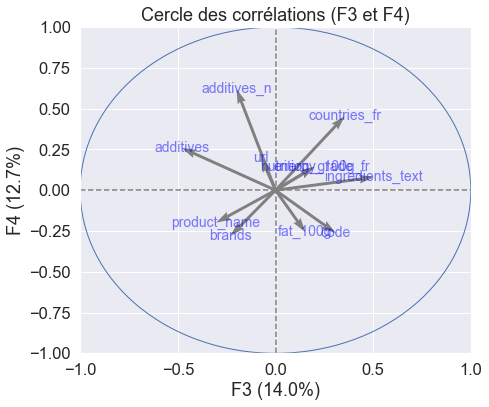

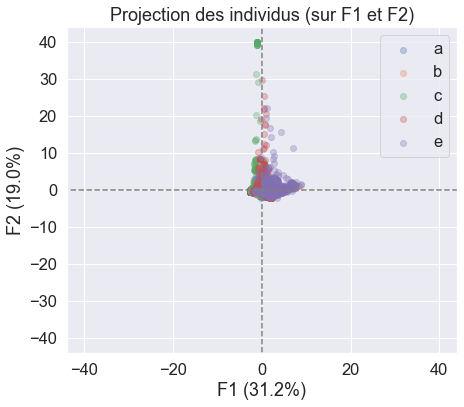

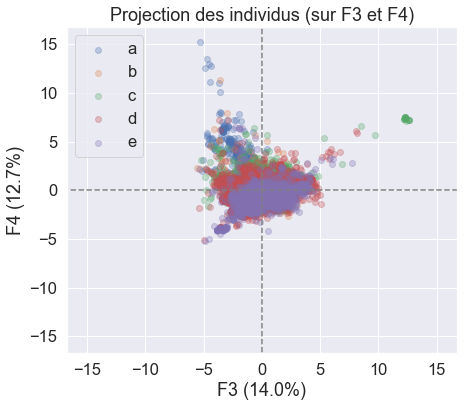

In [35]:
Colonnes = ['code', 'url', 'product_name', 'brands', 'countries_fr', 'ingredients_text', 
                 'additives_n', 'additives', 'nutrition_grade_fr', 'energy_100g', 
                 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 
                 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']


# import de l'échantillon
data = Food[Colonnes].sample(frac=0.15)

# selection des colonnes à prendre en compte dans l'ACP
data_pca = Food.select_dtypes(include=['float64'])

# choix du nombre de composantes à calculer
n_comp = 4

# préparation des données pour l'ACP
X = data_pca.values
names = Food['product_name']
features = Food.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


# Cercle des corrélations
pcs = pca.components_

# Projection des individus
X_projected = pca.transform(X_scaled)
grade = [Food.loc[index, "nutrition_grade_fr"] for index in Food.index]

# Eboulis des valeurs propres
display_scree_plot(pca)

display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)],  illustrative_var = grade, alpha=.3)
#rajouter le plot car couleur de classe a bc e (rajouetr le grade )
plt.show()

ANOVA

In [38]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [39]:
X = Food['nutrition_grade_fr'] # qualitative
Y = Food['fat_100g'] # quantitative
    
eta_squared(X,Y)

0.31302844683535097

In [40]:
Y = Food['energy_100g']

eta_squared(X,Y)

0.30650849563200305

In [41]:
Y = Food['saturated-fat_100g']
eta_squared(X,Y)

0.3719535231469069

In [42]:
Y = Food['carbohydrates_100g']
eta_squared(X,Y)

0.0669800147472224

In [43]:
Y = Food['sugars_100g']
eta_squared(X,Y)

0.24111134369228168

In [44]:
Y = Food['fiber_100g']
eta_squared(X,Y)

0.03734590014756734

In [45]:
Y = Food['proteins_100g']
eta_squared(X,Y)

0.01998887430119569

In [46]:
Y = Food['salt_100g']
eta_squared(X,Y)

0.014532130449342293

In [47]:
Y = Food['sodium_100g']
eta_squared(X,Y)

0.014531313978831199

In [48]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [49]:
anova_fat = smf.ols('fat_100g~nutrition_grade_fr', data=Food).fit()
print(anova_fat.summary())
sm.stats.anova_lm(anova_fat, typ=2)

                            OLS Regression Results                            
Dep. Variable:               fat_100g   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     2731.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:46:35   Log-Likelihood:                -93030.
No. Observations:               23982   AIC:                         1.861e+05
Df Residuals:                   23977   BIC:                         1.861e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

,sum_sq,df,F,PR(>F)
nutrition_grade_fr,1.497764e+06,4.0,2731.366035,0.0
Residual,3.286990e+06,23977.0,NaN,NaN


In [50]:
anova_energy = smf.ols('energy_100g~nutrition_grade_fr', data=Food).fit()
print(anova_energy.summary())
sm.stats.anova_lm(anova_energy, typ=2)

                            OLS Regression Results                            
Dep. Variable:            energy_100g   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     2649.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:46:35   Log-Likelihood:            -1.8818e+05
No. Observations:               23982   AIC:                         3.764e+05
Df Residuals:                   23977   BIC:                         3.764e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

,sum_sq,df,F,PR(>F)
nutrition_grade_fr,4.057914e+09,4.0,2649.331013,0.0
Residual,9.181243e+09,23977.0,NaN,NaN


In [51]:
anova_variete_phyto = smf.ols('energy_100g~nutrition_grade_fr*fat_100g', data=Food).fit()
print(anova_variete_phyto.summary())
sm.stats.anova_lm(anova_variete_phyto)

                            OLS Regression Results                            
Dep. Variable:            energy_100g   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     4318.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:46:35   Log-Likelihood:            -1.8101e+05
No. Observations:               23982   AIC:                         3.620e+05
Df Residuals:                   23972   BIC:                         3.621e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

,df,sum_sq,mean_sq,F,PR(>F)
nutrition_grade_fr,4.0,4.057914e+09,1.014479e+09,4815.013106,0.000000e+00
fat_100g,1.0,4.023771e+09,4.023771e+09,19097.997377,0.000000e+00
nutrition_grade_fr:fat_100g,4.0,1.067946e+08,2.669866e+07,126.719675,2.997367e-107
Residual,23972.0,5.050678e+09,2.106907e+05,NaN,NaN


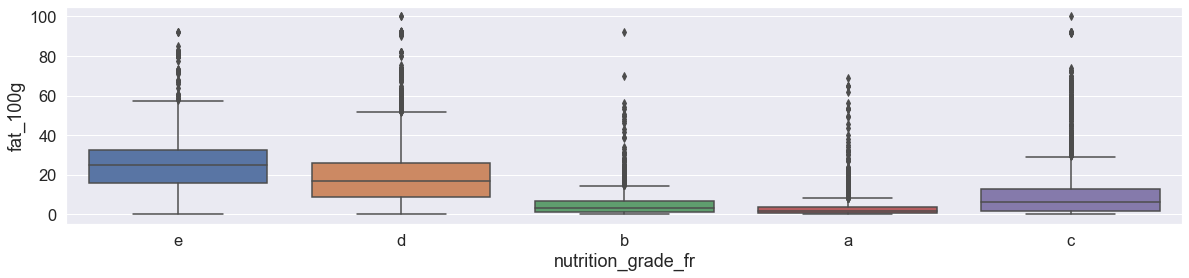

In [52]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['fat_100g'], data=Food)

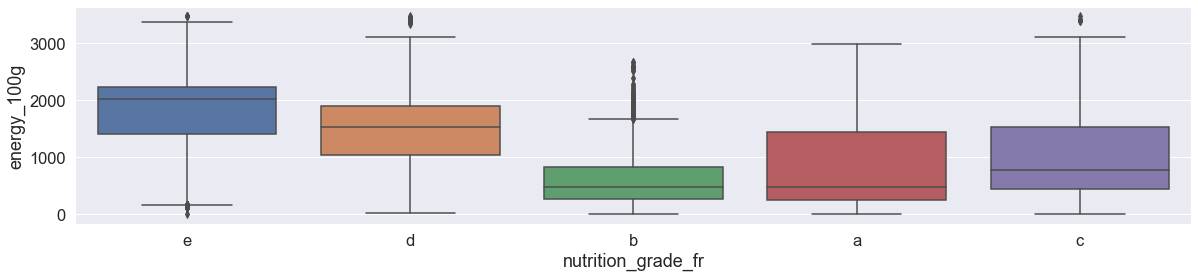

In [53]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['energy_100g'], data=Food)

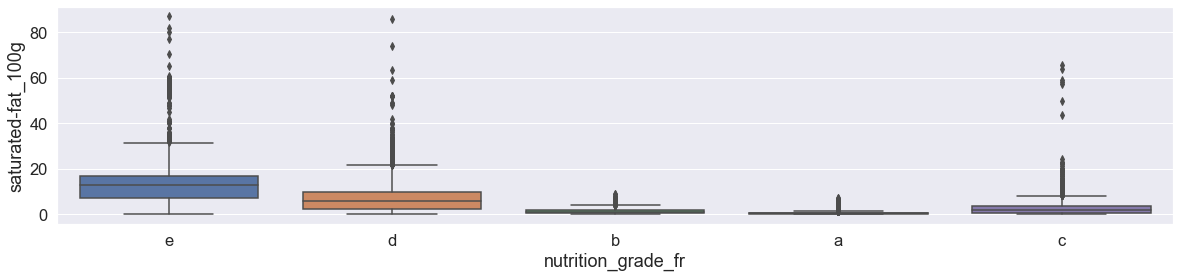

In [54]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['saturated-fat_100g'], data=Food)

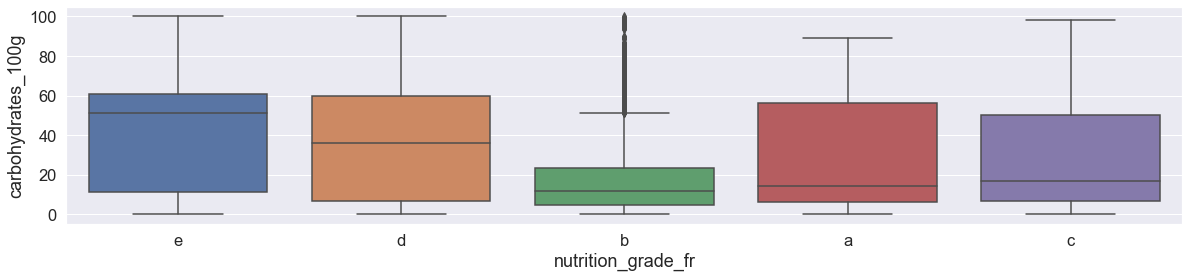

In [55]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['carbohydrates_100g'], data=Food)

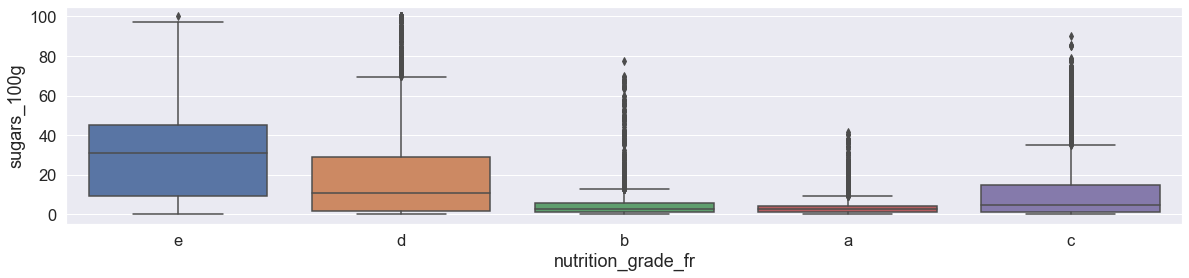

In [56]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['sugars_100g'], data=Food)

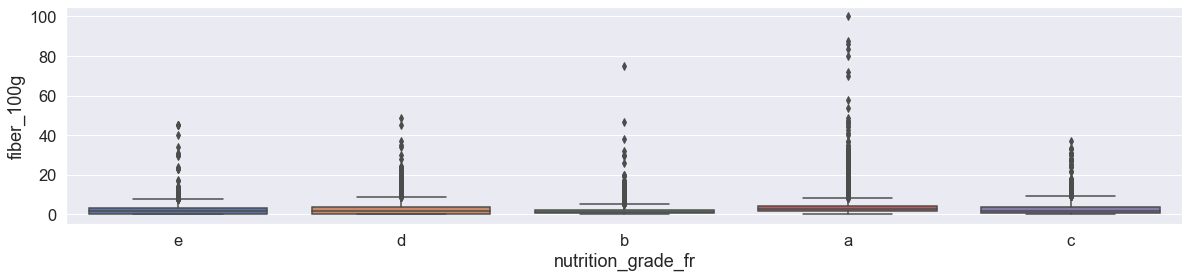

In [57]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['fiber_100g'], data=Food)

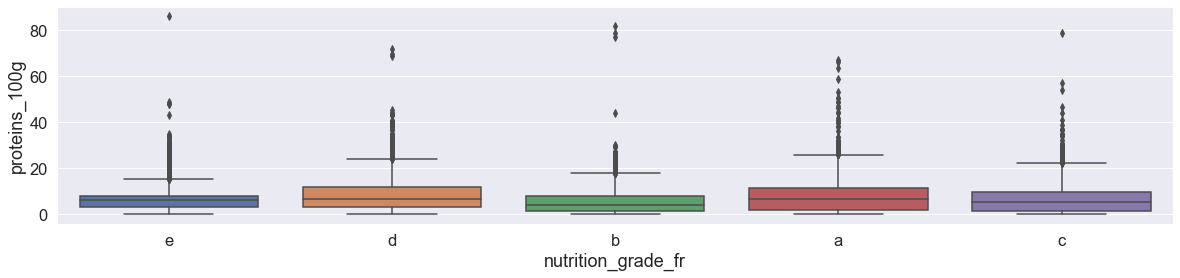

In [58]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['proteins_100g'], data=Food)

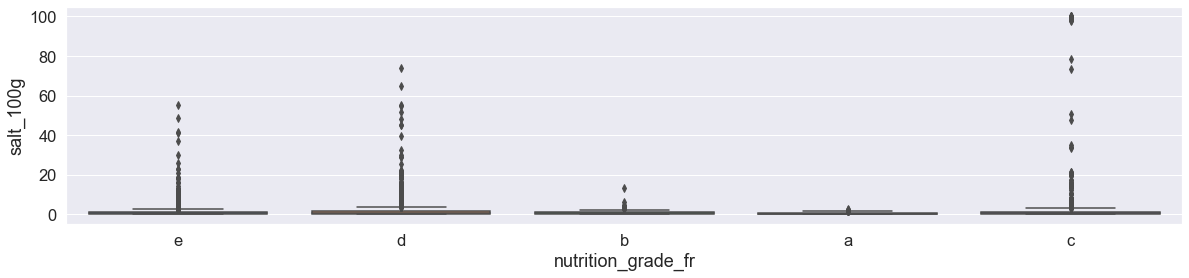

In [59]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['salt_100g'], data=Food)

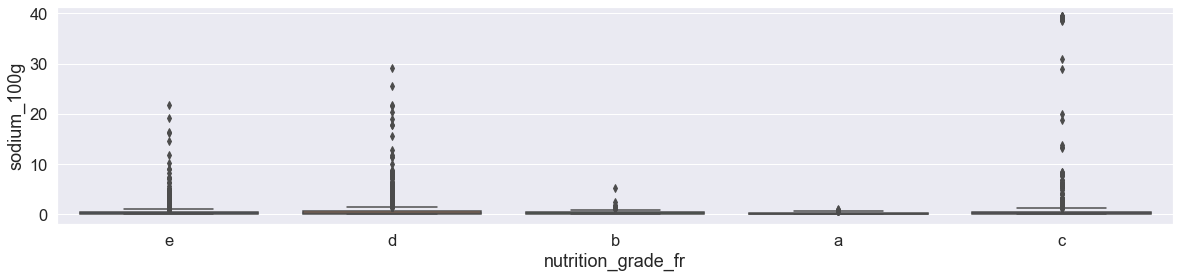

In [60]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x=Food['nutrition_grade_fr'], y=Food['sodium_100g'], data=Food)